In [1]:
import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import config
from utils import *
from keras.preprocessing.image import ImageDataGenerator
from seg_train_generator import *

seed = 42
np.random.seed = seed

IMG_WIDTH = None
IMG_HEIGHT = None
IMG_CHANNELS = 3

do = 0.1
iteration = 2
kernel = 32

#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(kernel, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(kernel, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(kernel * 2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(kernel * 2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(kernel * 4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(kernel * 4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(kernel * 8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(kernel * 8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(kernel * 16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(kernel * 16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(kernel * 8, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(kernel * 8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(kernel * 8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(kernel * 4, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(kernel * 4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(kernel * 4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(kernel * 2, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(kernel * 2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(kernel * 2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(kernel, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(kernel, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(kernel, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [2]:

################################
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_seg.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='accuracy'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]


In [3]:


# convert_ppm_to_png(config.TRAIN_DIR_SEG, f'{config.TRAIN_DIR_SEG}/png/')
# convert_ppm_to_png(config.LABEL_DIR_SEG, f'{config.LABEL_DIR_SEG}/png/')

image_dir = config.TRAIN_DIR_SEG# directory with clean images
label_dir = config.LABEL_DIR_SEG # directory with noisy images file names same as filenames in clean dir
shuffle = False # if True shuffles the dataframe
df = create_df(image_dir, label_dir ,shuffle) # create a dataframe with columns 'images' , 'labels'
                                            # where labels are the noisy images
                                            


In [4]:
train_split = .8 # use 80% of files for training
test_split = .1  # use 10% for test, automatically sets validation split at 1-train_split-test_split
batch_size = 5 # set batch_size
height = 256 # set image height for generator output images and labels
width = 256 # set image width for generator output images and labels
channels = 3 # set number of channel in images
image_shape = (height, width) 
rescale = 1/255  # set value to rescale image pixels


In [5]:
gen = jpgen(df, train_split=train_split, test_split=test_split) # create instance of generator class
tr_gen_len = gen.tr_gen_len
test_gen_len = gen.test_gen_len
valid_gen_len = gen.valid_gen_len   
test_filenames = gen.test_gen_filenames # names of test file paths used for training 
train_steps = tr_gen_len//batch_size #  use this value in for steps_per_epoch in model.fit
valid_steps = valid_gen_len//batch_size # use this value for validation_steps in model.fit
test_steps = test_gen_len//batch_size  # use this value for steps in model.predict

# instantiate generators
train_gen = gen.flow(batch_size=batch_size, image_shape=image_shape, rescale=rescale, shuffle=False, subset='training', random_factor=0.7)
valid_gen = gen.flow(batch_size=batch_size, image_shape=image_shape, rescale=rescale, shuffle=False, subset='valid', random_factor=0.7)
test_gen = gen.flow(batch_size=batch_size, image_shape=image_shape, rescale=rescale, shuffle=False, subset='test', random_factor=0.7)


In [6]:

results = model.fit(train_gen, batch_size=5, epochs=50, callbacks=callbacks, steps_per_epoch=50*train_steps, validation_steps=valid_steps, validation_data=valid_gen,  shuffle=True) # 20 num de fotos, 5 batch

# predictions=model.predict(test_gen, steps=test_steps)

# print(predictions)

Epoch 1/50
150/150 [==============================] - 1615s 11s/step - loss: 0.2552 - accuracy: 0.8950
Epoch 2/50
150/150 [==============================] - 1542s 10s/step - loss: 0.1458 - accuracy: 0.9203
Epoch 3/50
150/150 [==============================] - 1537s 10s/step - loss: 0.1091 - accuracy: 0.9311
Epoch 4/50
150/150 [==============================] - 1530s 10s/step - loss: 0.0882 - accuracy: 0.9369
Epoch 5/50
150/150 [==============================] - 1535s 10s/step - loss: 0.0780 - accuracy: 0.9394
Epoch 6/50
150/150 [==============================] - 1554s 10s/step - loss: 0.0713 - accuracy: 0.9411
Epoch 7/50
150/150 [==============================] - 1526s 10s/step - loss: 0.0658 - accuracy: 0.9423
Epoch 8/50
150/150 [==============================] - 1530s 10s/step - loss: 0.0619 - accuracy: 0.9432
Epoch 9/50
150/150 [==============================] - 1550s 10s/step - loss: 0.0594 - accuracy: 0.9437
Epoch 10/50
150/150 [==============================] - 1532s 10s/step - l

In [7]:
model.save_weights('./output/teste_promissor_2_13_02')
model.save('./output/model_teste_promissor_2_13_02')

INFO:tensorflow:Assets written to: ./output/model_teste_promissor_2_13_02\assets


INFO:tensorflow:Assets written to: ./output/model_teste_promissor_2_13_02\assets


In [8]:
model.save('my_model_13-02.h5')

In [17]:
img = tf.keras.preprocessing.image.load_img('./datasets/PROCESSED/TESTE/1/parte_3_1493.png', target_size=(256,256))
img_tensor = tf.keras.preprocessing.image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

In [18]:
predictions = model.predict(img_tensor)

1/1 [==============================] - 0s 355ms/step


In [19]:
len(predictions)

1

In [20]:
output_2d = predictions.squeeze()
pred = 255. * (predictions - np.min(predictions)) / (np.max(predictions) - np.min(predictions))
cv2.imwrite("teste.png", pred.squeeze())

True

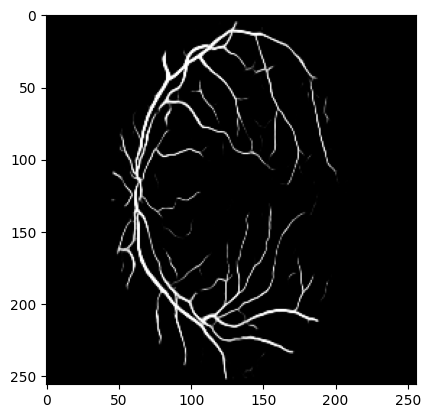

In [21]:
plt.imshow(output_2d, cmap='gray')
plt.show()